In [1]:
!pip install pymysql

In [2]:
import pymysql
import pandas as pd
from shapely import wkt
import geopandas
import matplotlib.pyplot as plt
from pysal.lib import weights
import contextily
import seaborn
from pysal.explore import esda
from splot.esda import plot_moran
from pysal.model import spreg 
import numpy as np
import matplotlib as mpl

In [3]:
def conn(host,port,db):
    db_settings = {
        "host": host,
        "port": port,
        "user": "root",
        "password": "",
        "db": db,
        "charset": "utf8",
        "connect_timeout":31536000
    }

    try:
        conn = pymysql.connect(**db_settings)
        print("success connect to bo!!")
    except Exception as ex:
        conn = None
        print(ex)
    return conn

def query(conn,command):
    with conn.cursor() as cursor:
        cursor.execute(command)
        result = cursor.fetchall()
        return result  

In [4]:
# 設定字型
font = mpl.font_manager.FontProperties(fname="./微軟正黑體-1.ttf")
mpl.rcParams['axes.unicode_minus']=False

-----
# Contiguity Weights空間相鄰權重矩陣

In [5]:
# 資料庫連線
c = conn("house_bo",3306,"bigobject")

success connect to bo!!


In [6]:
# 取出資料放入dataframe
code02 = pd.DataFrame(query(c,"select * from house.area_code2 where city in ('臺北市','新北市')"))
code02 = code02.set_axis(['code2', 'townid', 'town', 'city_id', 'city','u_id',"area",'y','x','geometry','polygon'], axis=1, inplace=False)
code02.head(3)

,code2,townid,town,city_id,city,u_id,area,y,x,geometry,polygon
0,A6501-05,65000010,板橋區,65000,新北市,5,56593.5443,25.032466,121.476122,MULTIPOLYGON (((121.4760850367192 25.033266967...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...
1,A6501-06,65000010,板橋區,65000,新北市,6,41802.6326,25.032153,121.470141,MULTIPOLYGON (((121.4710964634274 25.032148007...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...
2,A6501-07,65000010,板橋區,65000,新北市,7,49451.5894,25.031605,121.477198,MULTIPOLYGON (((121.4793620134134 25.031974856...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...


In [7]:
# dataframe -> geodataframe
code02['geometry'] = geopandas.GeoSeries.from_wkt(code02['geometry'])
gdf = geopandas.GeoDataFrame(code02, geometry='geometry')

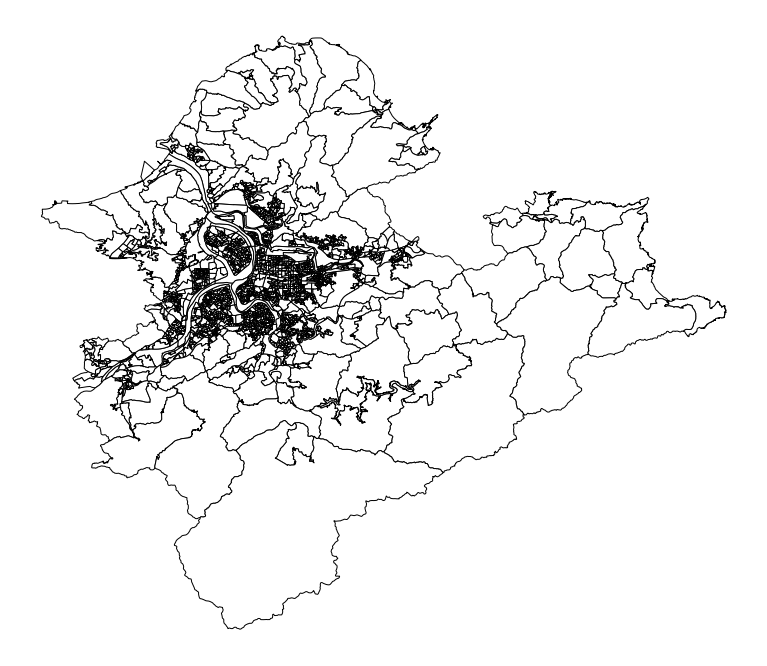

In [8]:
# 畫出邊界
base = gdf.plot(facecolor='w', edgecolor='k',figsize=(16, 12))
base.set_axis_off()
plt.show()

## 1.Rook:多邊形共用同一個邊

In [9]:
# 空間相鄰矩陣
wr = weights.contiguity.Rook.from_dataframe(gdf)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 11 islands with ids: 327, 830, 1237, 1241, 1288, 1367, 1641, 1647, 1711, 1782, 1830.
  warnings.warn(message)


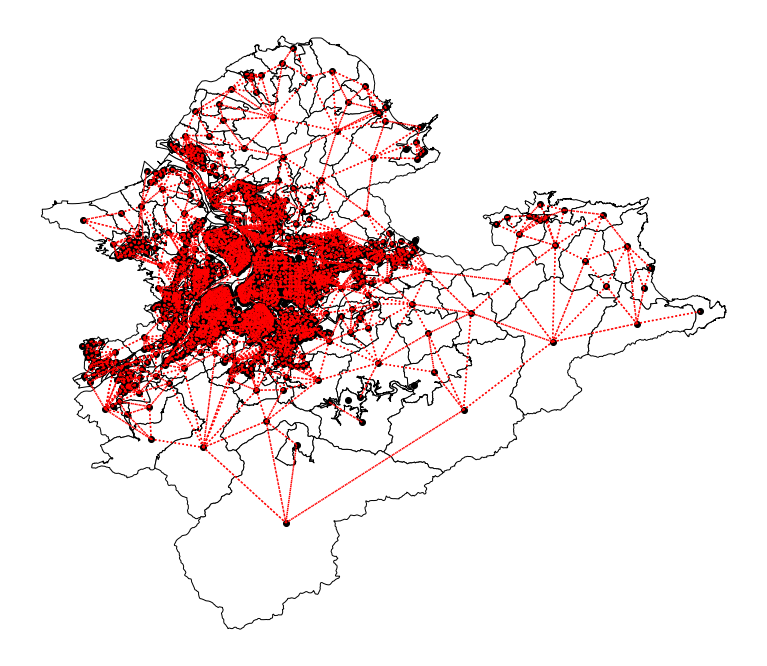

In [10]:
# Set up figure
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'),figsize=(16, 12))
# Plot grid
gdf.plot(facecolor='w', edgecolor='k', ax=ax)

# Plot weights connectivity
wr.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
# Remove axes
ax.set_axis_off()

In [11]:
# 計算非0的數量
wr.nonzero

12088

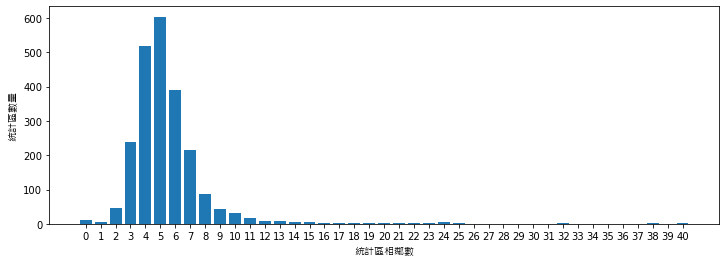

In [12]:
plt.figure(figsize=(12,4))
plt.bar(pd.DataFrame(wr.histogram)[0],pd.DataFrame(wr.histogram)[1], align='center')
plt.xticks(pd.DataFrame(wr.histogram)[0])
plt.ylabel('統計區數量',fontproperties=font)
plt.xlabel('統計區相鄰數',fontproperties=font)
#plt.title('Programming language usage')
plt.show()

In [13]:
print("連接數："+str(wr.s0))
print("連接密度(連接數/空間數^2 = 40 / 9^2)："+str(round(wr.pct_nonzero,3)))

連接數：12088.0
連接密度(連接數/空間數^2 = 40 / 9^2)：0.239


## 2.Queen:多邊形共用一個或多個點

In [14]:
# 空間相鄰矩陣
wq = weights.contiguity.Queen.from_dataframe(gdf)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 10 islands with ids: 327, 830, 1237, 1288, 1367, 1641, 1647, 1711, 1782, 1830.
  warnings.warn(message)


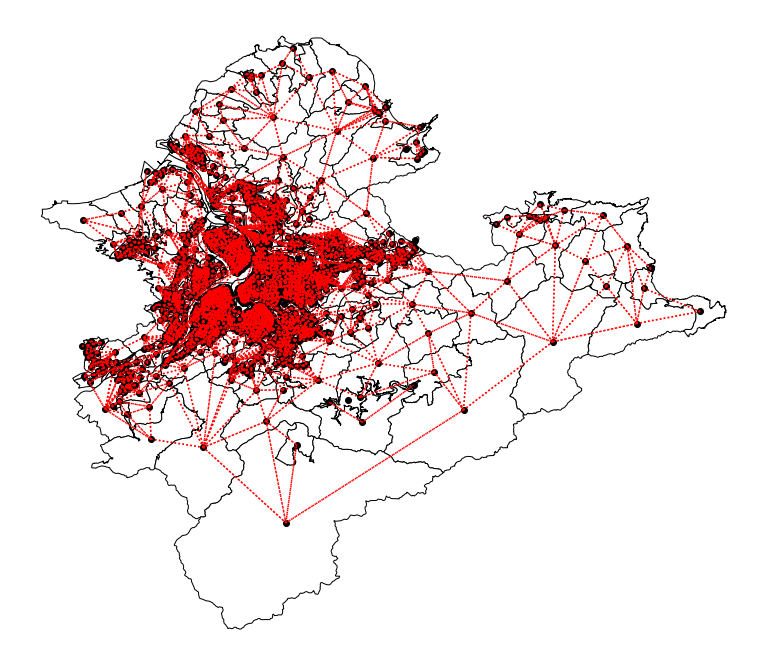

In [15]:
# Set up figure
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'),figsize=(16, 12))
# Plot grid
gdf.plot(facecolor='w', edgecolor='k', ax=ax)

# Plot weights connectivity
wq.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
# Remove axes
ax.set_axis_off()

In [16]:
# 計算非0的數量
wq.nonzero

13366

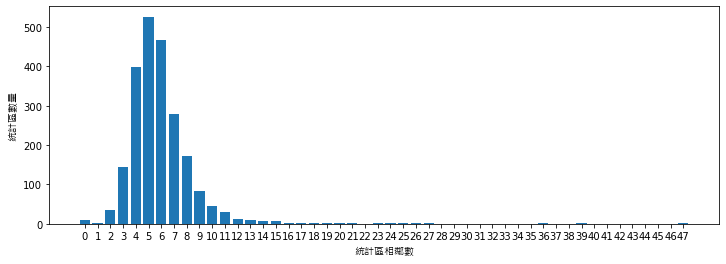

In [17]:
plt.figure(figsize=(12,4))
plt.bar(pd.DataFrame(wq.histogram)[0],pd.DataFrame(wq.histogram)[1], align='center')
plt.xticks(pd.DataFrame(wq.histogram)[0])
plt.ylabel('統計區數量',fontproperties=font)
plt.xlabel('統計區相鄰數',fontproperties=font)
#plt.title('Programming language usage')
plt.show()

In [18]:
print("連接數："+str(wq.s0))
print("連接密度(連接數/空間數^2 = 40 / 9^2)："+str(round(wq.pct_nonzero,3)))

連接數：13366.0
連接密度(連接數/空間數^2 = 40 / 9^2)：0.264


-----------------
# 預處理

In [19]:
# 資料庫連線
m = conn("house_master",3306,"bigobject")

success connect to bo!!


In [20]:
condition = "city in ('臺北市','新北市') and not transaction_sign in ('車位','土地')  and tgosresaddress <> '找不到指定的門牌地址。' and trans_date <> null and complete_date <> null and complete_date <= trans_date"
period = "'108S1','108S2','108S3','108S4','109S1','109S2','109S3','109S4','110S1','110S2','110S3','110S4'"

In [21]:
# 單價分佈(by季)
sql = "select database(),min(unit_price),QUANTILE(unit_price,0.05),QUANTILE(unit_price,0.95),max(unit_price),avg(unit_price),std(unit_price),count(*) from house_buy  where " + condition
sql = "remote "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["period","min_unit_price","qt5","qt95","max_unit_price","avg_unit_price","std_unit_price","count"], axis=1, inplace=False)
data

,period,min_unit_price,qt5,qt95,max_unit_price,avg_unit_price,std_unit_price,count
0,109S1,0,50568.45,252307.15,1617512,128052.858659,7.155934e+04,14044
1,108S4,0,51267.80,248116.40,2211457,126010.099936,6.925584e+04,14129
2,109S2,0,48853.45,245417.70,2030431,126142.814436,7.054928e+04,13300
3,108S2,0,49579.20,245039.60,1212274,123233.049228,6.752619e+04,13285
4,109S3,0,51033.00,252067.40,1307432,129032.641744,6.866713e+04,21373
5,108S1,0,47654.05,242122.80,960615,120861.608891,6.838073e+04,12462
6,110S1,0,53821.40,260538.00,1086122,134191.521660,7.196664e+04,14889
7,108S3,0,49898.10,251041.10,885851,126128.455976,6.852298e+04,14935
8,109S4,0,54462.55,257842.70,1224547,133076.423811,6.971643e+04,17614
9,110S2,0,54809.40,260890.25,1827767,134857.727085,7.044969e+04,17478


In [22]:
# 單價分佈(by季,區)
sql = "select database(),concat(city,town) as area,min(unit_price),QUANTILE(unit_price,0.05),QUANTILE(unit_price,0.95),max(unit_price),avg(unit_price),std(unit_price),count(*) from house_buy "
sql = sql + " where " + condition + " group by area"
sql = "remote "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["period","area","min_unit_price","qt5","qt95","max_unit_price","avg_unit_price","std_unit_price","count"], axis=1, inplace=False)
data

,period,area,min_unit_price,qt5,qt95,max_unit_price,avg_unit_price,std_unit_price,count
0,108S1,臺北市文山區,34689,82499.05,212297.80,412327,141673.583333,41764.739603,312
1,108S1,臺北市中正區,44984,76194.25,374707.75,906363,226460.137755,98053.950792,196
2,108S1,臺北市萬華區,15132,60769.20,239963.05,355958,157798.915344,58637.882343,378
3,108S1,臺北市大同區,48247,90694.10,236920.30,381328,164026.333333,51402.751768,150
4,108S1,臺北市內湖區,0,96028.00,251098.75,462321,160346.177632,47872.953854,456
...,...,...,...,...,...,...,...,...,...
456,109S3,新北市瑞芳區,10655,13839.55,66198.90,83573,33140.700000,17751.359640,30
457,109S3,新北市金山區,22406,23737.05,62333.75,124277,45667.958333,16630.961360,48
458,109S3,新北市貢寮區,18684,19490.10,28065.30,28212,24547.000000,4188.802454,3
459,109S3,新北市雙溪區,19375,20348.40,70914.80,80202,36494.600000,22341.450925,5


In [23]:
# 原始資料
sql = "select concat(city,town) as area ,unit_price from house_buy  where " + condition
sql = "cluster "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["area","unit_price"], axis=1, inplace=False)

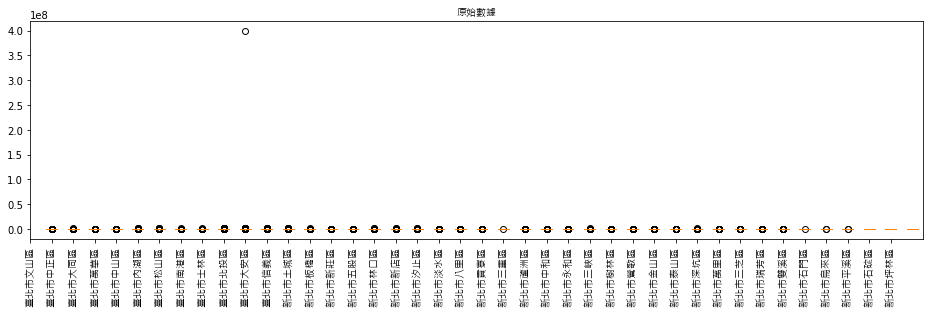

In [24]:
data_2d = []
for i in data['area'].unique():
    data_2d.append(list(data[data['area'] == i]['unit_price']))
plt.figure(figsize=(16,4))
plt.boxplot(data_2d,vert=True)
plt.title("原始數據",fontproperties=font)
plt.xticks(np.arange(len(data['area'].unique())), list(data['area'].unique()), rotation ='vertical',fontproperties=font)
plt.show()

In [25]:
# 截尾平均
sql = "select city,town,QUANTILE(unit_price,0.05) as down_bond,QUANTILE(unit_price,0.95) as up_bond from house_buy where " + condition + " group by city,town"
sql = "select concat(city,town) as area ,unit_price from house_buy a inner join ("+sql+") b on a.city = b.city and a.town = b.town"
sql = sql + " where " + condition + " and a.unit_price >= b.down_bond and a.unit_price <= b.up_bond"
sql = "cluster "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["area","unit_price"], axis=1, inplace=False)

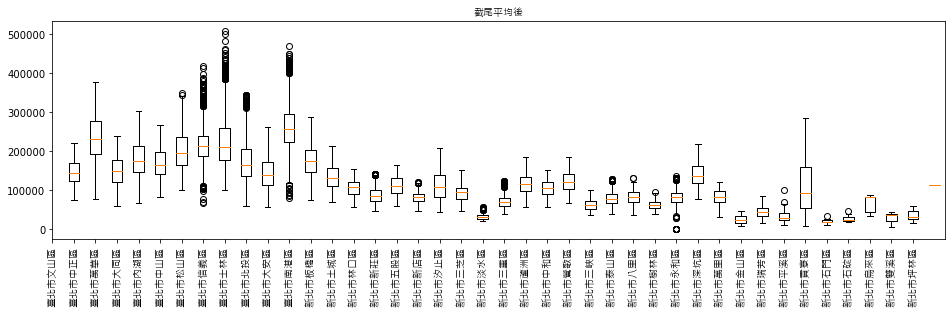

In [26]:
data_2d = []
for i in data['area'].unique():
    data_2d.append(list(data[data['area'] == i]['unit_price']))
plt.figure(figsize=(16,4))
plt.boxplot(data_2d,vert=True)
plt.title("截尾平均後",fontproperties=font)
plt.xticks(np.arange(len(data['area'].unique())), list(data['area'].unique()), rotation ='vertical',fontproperties=font)
plt.show()

In [27]:
# 截尾後單價分佈(by季)
sql = "select city,town,QUANTILE(unit_price,0.05) as down_bond,QUANTILE(unit_price,0.95) as up_bond from house_buy where " + condition + " group by city,town"
sql = "select database(),min(unit_price),max(unit_price),avg(unit_price),std(unit_price),count(*) from house_buy a inner join ("+sql+") b on a.city = b.city and a.town = b.town "
sql = sql + " where " + condition + " and a.unit_price >= b.down_bond and a.unit_price <= b.up_bond"
sql = "remote "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["period","min_unit_price","max_unit_price","avg_unit_price","std_unit_price","count"], axis=1, inplace=False)
data

,period,min_unit_price,max_unit_price,avg_unit_price,std_unit_price,count
0,108S1,8155,469078,118892.461676,55825.842468,11181
1,109S1,9427,482141,126036.362454,57213.576280,12614
2,109S2,0,508133,124408.133568,56645.165789,11949
3,110S1,10526,500204,132196.776207,59448.475445,13365
4,108S2,8947,383884,121503.465409,55226.063465,11925
5,108S3,13158,427735,124581.330077,57785.714058,13409
6,109S4,8669,450702,131089.195803,58264.906917,15822
7,110S2,10650,420198,133100.313367,59664.994037,15710
8,108S4,4042,433364,124317.242002,55755.274254,12690
9,109S3,7855,388700,127342.817292,56940.105045,19200


In [28]:
# 截尾後單價分佈(by季,區)
sql = "select city,town,QUANTILE(unit_price,0.05) as down_bond,QUANTILE(unit_price,0.95) as up_bond from house_buy where " + condition + " group by city,town"
sql = "select database(),concat(city,town) as area,min(unit_price),max(unit_price),avg(unit_price),std(unit_price),count(*) from house_buy a inner join ("+sql+") b on a.city = b.city and a.town = b.town "
sql = sql + " where " + condition + " and a.unit_price >= b.down_bond and a.unit_price <= b.up_bond group by area"
sql = "remote "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["period","area","min_unit_price","max_unit_price","avg_unit_price","std_unit_price","count"], axis=1, inplace=False)
data

,period,area,min_unit_price,max_unit_price,avg_unit_price,std_unit_price,count
0,109S2,臺北市文山區,75181,210467,140929.102339,32489.763503,342
1,109S2,臺北市中正區,107385,350762,226724.657534,53517.777364,219
2,109S2,臺北市萬華區,77528,202223,142728.099099,32846.535088,222
3,109S2,臺北市大同區,77653,252466,171428.459596,41386.159895,198
4,109S2,臺北市內湖區,86496,235900,164295.896926,38245.821918,553
...,...,...,...,...,...,...,...
443,110S4,新北市萬里區,11496,47073,26365.232558,9596.626919,43
444,110S4,新北市瑞芳區,20219,69559,39308.125000,12666.578489,24
445,110S4,新北市金山區,32498,81351,53715.900000,14860.554670,40
446,110S4,新北市石碇區,49869,49869,49869.000000,0.000000,1


In [29]:
sql = "cluster select count(*) from house_buy where city in ('臺北市','新北市') partition by db in ("+period+")"
pd.DataFrame(query(m,sql))[0][0]   #257690

257690

In [30]:
# condition1
sql = "cluster select count(*) from house_buy where city in ('臺北市','新北市') and transaction_sign in ('車位','土地') partition by db in ("+period+")"
pd.DataFrame(query(m,sql))[0][0]   #35925

35925

In [31]:
# condition2
sql = "cluster select count(*) from house_buy where city in ('臺北市','新北市')  and not transaction_sign in ('車位','土地') and tgosresaddress = '找不到指定的門牌地址。' partition by db in ("+period+")"
pd.DataFrame(query(m,sql))[0][0]   #888

888

In [32]:
# condition3
sql = "cluster select count(*) from house_buy where city in ('臺北市','新北市') and not transaction_sign in ('車位','土地') and tgosresaddress <> '找不到指定的門牌地址。' and (trans_date = null or complete_date = null or complete_date > trans_date) partition by db in ("+period+")"
pd.DataFrame(query(m,sql))[0][0]   #38039

38039

In [33]:
# condition4
sql = "select city,town,QUANTILE(unit_price,0.05) as down_bond,QUANTILE(unit_price,0.95) as up_bond from house_buy where " + condition + " group by city,town"
sql = "select count(*) from house_buy a inner join ("+sql+") b on a.city = b.city and a.town = b.town"
sql = sql + " where " + condition + " and (a.unit_price < b.down_bond or a.unit_price > b.up_bond)"
sql = "cluster "+ sql + " partition by db in ("+period+")"
pd.DataFrame(query(m,sql))[0][0]   #18644

18644

In [34]:
sql = "select city,town,QUANTILE(unit_price,0.05) as down_bond,QUANTILE(unit_price,0.95) as up_bond from house_buy where " + condition + " group by city,town"
sql = "select count(*) from house_buy a inner join ("+sql+") b on a.city = b.city and a.town = b.town"
sql = sql + " where " + condition + " and (a.unit_price >= b.down_bond and a.unit_price <= b.up_bond)"
sql = "cluster "+ sql + " partition by db in ("+period+")"
pd.DataFrame(query(m,sql))[0][0]   #164194

164194

-----------------
# 敘述統計

In [35]:
# 資料庫連線
m = conn("house_master",3306,"bigobject")

success connect to bo!!


In [36]:
house_var = [
    'unit_price * 1.00 / 10000 as unit_price_w',  #y單價
    'area',            #x1土地移轉總面積平方公尺
    'year(trans_date) - year(complete_date) as age',     
                       #x2屋齡
    'shifting_area',   #x3建物移轉總面積平方公尺
    'pattern_room',    #x4建物現況格局-房
    'pattern_hall',    #x5建物現況格局-廳
    'pattern_health',  #x6建物現況格局-衛
    'building_area'    #x7主建物面積
]

In [37]:
other_var = [
    'mrtstation',           #x8臺北捷運車站
    'busstation',           #x9公車站
    'tymetrostation',       #x10機場捷運
    'shopfamily + shophilife + shopokmart + shopseven as store',
                            #x11便利商店(全家+7-11+萊爾富+ok)
    'simplemart',           #x12美廉社
    'pxmart',               #x13全聯
    'carrefour',            #x14家樂福
    'costco',               #x15Costco
    'rtmart',               #x16大潤發
    'pharmarcy',            #x17藥局
    'policestation',        #x18警察局/派出所
    'firestation',          #x19消防隊
    'hospital',             #x20醫療院所
    'school',               #x21學校
    'incinerator',          #x22焚化廠
    'cleaningteam',         #x23全國各縣市清潔隊
    'cleaninginstitution',  #x24公民營廢棄物清除機構
    'recyclablesdepot',     #x25資源回收業
    'radio',                #x26電臺發射機
    'nuclear_powerplant',   #x27核能發電廠
    'gas_station',          #x28加油站
    'funeralfacilities',    #x29殯葬設施
    'temple',               #x30寺廟
    'ancestralhall',        #x31宗祠
    'wastewater',           #x32工業汙水處理
    'lpg',                  #x33液化石油氣分裝業
]

In [38]:
house_var_n = [v.split(" as ")[1] if " as " in v else v for v in house_var]
other_var_n = [v.split(" as ")[1] if " as " in v else v for v in other_var]

In [39]:
sql = "select city,town,QUANTILE(unit_price,0.05) as down_bond,QUANTILE(unit_price,0.95) as up_bond from house_buy where " + condition + " group by city,town"
sql = "select code2,"+",".join(house_var) + " from house_buy a inner join ("+sql+") b on a.city = b.city and a.town = b.town "
sql = sql + " where " + condition + " and a.unit_price >= b.down_bond and a.unit_price <= b.up_bond"
sql = "select code2,{} from ({}) group by code2".format(",".join(["avg("+v+") as "+v for v in house_var_n]),sql)
sql = "select code2,{},{},c.geometry as geometry from (cluster {} partition by db in ({})) a left join (cluster select code2,{} from code2 partition by db = 'unified') b on a.code2 = b.code2 inner join (cluster select * from area_code2 partition by db = 'house') c on a.code2 = c.code2".format(",".join(["a."+v+" as "+v for v in house_var_n]),",".join(["b."+v+" as "+v for v in other_var_n]),sql,period,','.join(other_var))
data = pd.DataFrame(query(m,sql))

In [40]:
data = data.set_axis(['code2']+house_var_n+other_var_n+['geometry'], axis=1, inplace=False)
data['geometry'] = geopandas.GeoSeries.from_wkt(data['geometry'])
data.head()

,code2,unit_price_w,area,age,shifting_area,pattern_room,pattern_hall,pattern_health,building_area,mrtstation,...,recyclablesdepot,radio,nuclear_powerplant,gas_station,funeralfacilities,temple,ancestralhall,wastewater,lpg,geometry
0,A6308-37,17.744496,31.293043,22.072464,134.774058,2.608696,1.666667,1.739130,77.954638,0,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.56388 24.99625, 121.56363 ..."
1,A6308-68,16.964316,31.266436,22.980198,124.734455,2.405941,1.623762,1.564356,76.798614,0,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.58536 24.98994, 121.58547 ..."
2,A6308-55,18.138316,32.612368,24.210526,129.128947,2.000000,1.447368,1.315789,82.248421,0,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.56344 24.99130, 121.56295 ..."
3,A6305-40,18.953515,29.399859,25.112676,124.392394,2.183099,1.521127,1.450704,82.319155,0,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.51906 25.02647, 121.51915 ..."
4,A6308-20,19.312234,22.616071,20.875000,118.527143,2.517857,1.482143,1.428571,71.620357,0,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.54693 25.00245, 121.54709 ..."


In [41]:
# 描述性統計
data.describe().T.to_csv("./desc.csv")  
data.describe().T

,count,mean,std,min,25%,50%,75%,max
unit_price_w,2198.0,13.645842,4.336646,1.744,10.043875,11.033755,18.286849,30.580200
area,2198.0,38.239473,434.769744,4.240,23.098505,26.032187,30.041778,20399.730000
age,2198.0,22.029385,4.832955,0.000,18.410117,22.000000,25.500000,44.000000
shifting_area,2198.0,136.350779,34.155826,62.345,121.036295,131.464393,143.361255,690.156562
pattern_room,2198.0,2.553890,0.355463,0.000,2.379310,2.551724,2.714286,13.000000
pattern_hall,2198.0,1.621392,0.151883,0.000,1.535267,1.625000,1.710526,2.946429
pattern_health,2198.0,1.593855,0.284796,0.000,1.482903,1.580323,1.681818,12.000000
building_area,2198.0,85.610921,21.869106,27.490,76.477703,82.039472,88.497539,466.879375
mrtstation,2198.0,0.171065,0.646295,0.000,0.000000,0.000000,0.000000,8.000000
busstation,2198.0,29.256597,23.284366,0.000,13.000000,26.000000,42.000000,171.000000


In [42]:
db = geopandas.GeoDataFrame(data)

/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/opt/conda/lib/python3.8/site-packages/mapclassify/clas

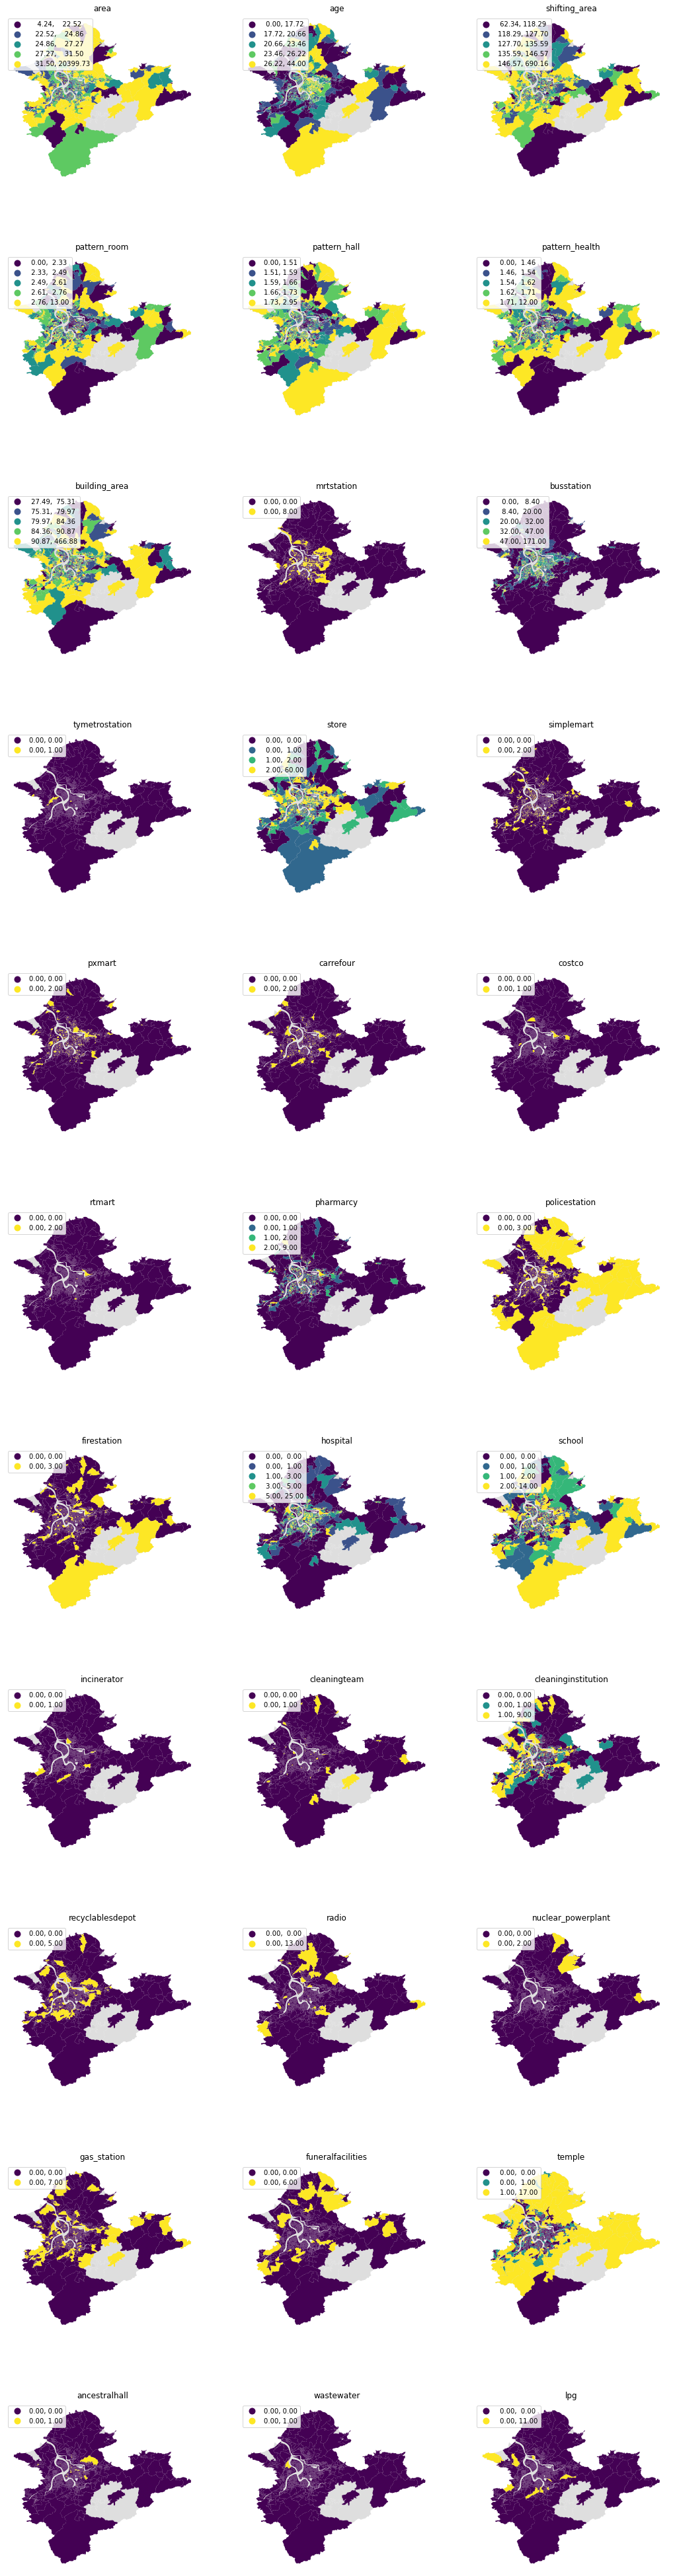

In [43]:
# 變數地圖
f, ax = plt.subplots(nrows=11, ncols=3,figsize=(18,72))
row = 0
col = 0
for var in house_var_n[1:]+other_var_n:
    gdf.plot(ax=ax[row,col],facecolor='lightgray', edgecolor='k',alpha=0.75,linewidth=0.,figsize=(16, 12))
    db.plot(column=var,cmap='viridis', scheme='quantiles',k=5, edgecolor='white', linewidth=0.,legend=True,legend_kwds={"loc": 2},ax=ax[row,col])
    ax[row,col].set_title(var)
    ax[row,col].set_axis_off()

    col = col + 1
    if col == 3:
        row = row + 1
        col = 0

--------
# VIF

In [44]:
dep_var = 'unit_price_w'
ind_var = []
for v in house_var_n:
    if v != dep_var:
        ind_var.append(v)
ind_var = ind_var + other_var_n

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(data[ind_var])
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const                  198.335589
area                     1.040038
age                      1.277854
shifting_area            3.286779
pattern_room             4.877900
pattern_hall             1.531280
pattern_health           3.992156
building_area            3.435736
mrtstation               1.339530
busstation               1.172385
tymetrostation           1.091251
store                    1.853054
simplemart               1.042867
pxmart                   1.044105
carrefour                1.068170
costco                   1.232166
rtmart                   1.235584
pharmarcy                1.555661
policestation            1.286818
firestation              1.177342
hospital                 1.807169
school                   1.130244
incinerator              1.152345
cleaningteam             1.069015
cleaninginstitution      1.108047
recyclablesdepot         1.217433
radio                    1.033157
nuclear_powerplant       1.115813
gas_station              1.435570
funeralfacilit

# Non-spatial regression

In [46]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    data[[dep_var]].values, 
    # Independent variables
    data[ind_var].values,
    # Dependent variable name
    name_y=dep_var, 
    # Independent variable name
    name_x=ind_var
)
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :unit_price_w                Number of Observations:        2198
Mean dependent var  :     13.6458                Number of Variables   :          34
S.D. dependent var  :      4.3366                Degrees of Freedom    :        2164
R-squared           :      0.5301
Adjusted R-squared  :      0.5229
Sum squared residual:   19417.000                F-statistic           :     73.9644
Sigma-square        :       8.973                Prob(F-statistic)     :           0
S.E. of regression  :       2.995                Log likelihood        :   -5513.109
Sigma-square ML     :       8.834                Akaike info criterion :   11094.219
S.E of regression ML:      2.9722                Schwarz criterion     :   11287.859

-----------------------------------------------------------------------------

-----------------
# Spatial Autocorrelation空間自相關

In [47]:
db['residual'] = m1.u

In [48]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2198 entries, 0 to 2197
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   code2                2198 non-null   object  
 1   unit_price_w         2198 non-null   float64 
 2   area                 2198 non-null   float64 
 3   age                  2198 non-null   float64 
 4   shifting_area        2198 non-null   float64 
 5   pattern_room         2198 non-null   float64 
 6   pattern_hall         2198 non-null   float64 
 7   pattern_health       2198 non-null   float64 
 8   building_area        2198 non-null   float64 
 9   mrtstation           2198 non-null   int64   
 10  busstation           2198 non-null   int64   
 11  tymetrostation       2198 non-null   int64   
 12  store                2198 non-null   int64   
 13  simplemart           2198 non-null   int64   
 14  pxmart               2198 non-null   int64   
 15  carrefour    

In [49]:
w = weights.contiguity.Rook.from_dataframe(db)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 3 islands with ids: 9, 2188, 2191.
  warnings.warn(message)


## 檢驗房屋單價
### 1.Global Autocorrelation

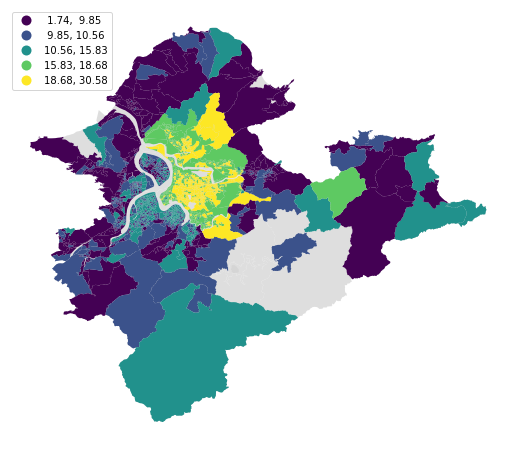

In [50]:
# 單價繪圖
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(ax=ax,facecolor='lightgray', edgecolor='k',alpha=0.75,linewidth=0.,figsize=(16, 12))
db.plot(column='unit_price_w', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax)
ax.set_axis_off()

In [51]:
# spatial_lag
db['unit_price_lag'] = weights.spatial_lag.lag_spatial(w, db['unit_price_w'])
db.head()

,code2,unit_price_w,area,age,shifting_area,pattern_room,pattern_hall,pattern_health,building_area,mrtstation,...,nuclear_powerplant,gas_station,funeralfacilities,temple,ancestralhall,wastewater,lpg,geometry,residual,unit_price_lag
0,A6308-37,17.744496,31.293043,22.072464,134.774058,2.608696,1.666667,1.739130,77.954638,0,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.56388 24.99625, 121.56363 ...",4.532199,105.708032
1,A6308-68,16.964316,31.266436,22.980198,124.734455,2.405941,1.623762,1.564356,76.798614,0,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.58536 24.98994, 121.58547 ...",2.107101,36.130154
2,A6308-55,18.138316,32.612368,24.210526,129.128947,2.000000,1.447368,1.315789,82.248421,0,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.56344 24.99130, 121.56295 ...",1.493103,54.141481
3,A6305-40,18.953515,29.399859,25.112676,124.392394,2.183099,1.521127,1.450704,82.319155,0,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.51906 25.02647, 121.51915 ...",2.312384,119.873071
4,A6308-20,19.312234,22.616071,20.875000,118.527143,2.517857,1.482143,1.428571,71.620357,0,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.54693 25.00245, 121.54709 ...",6.259805,102.924115


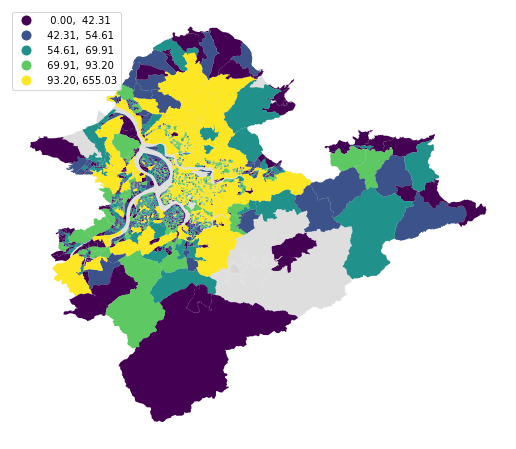

In [52]:
# spatial lag繪圖
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(ax=ax,facecolor='lightgray', edgecolor='k',alpha=0.75,linewidth=0.,figsize=(16, 12))
db.plot(column='unit_price_lag', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax)
ax.set_axis_off()

In [53]:
# 單價和單價lag標準化
db['unit_price_std'] = (db['unit_price_w'] - db['unit_price_w'].mean()) / db['unit_price_w'].std()
db['unit_price_lag_std'] = ( db['unit_price_lag'] - db['unit_price_lag'].mean()) / db['unit_price_lag'].std()

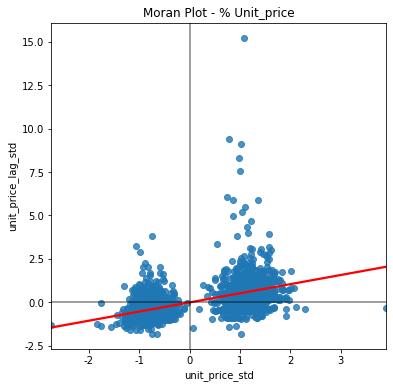

In [54]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(x='unit_price_std', y='unit_price_lag_std', 
                ci=None, data=db, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Unit_price')
plt.show()

In [55]:
# 計算moran's i
moran = esda.moran.Moran(db['unit_price_w'], w)
moran.I

('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 2188, ' is an island (no neighbors)')
('WARNING: ', 2191, ' is an island (no neighbors)')


0.9440142677399672

In [56]:
# empirical p-value:夠小的p-vale允許拒絕地圖是隨機的假設
moran.p_sim

0.001

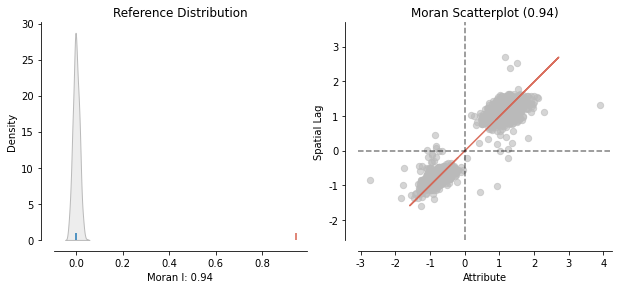

In [57]:
plot_moran(moran);

### 2.Local Autocorrelation

In [58]:
db['w_unit_price_std'] = ( db['unit_price_lag'] - db['unit_price_w'].mean() ) / db['unit_price_w'].std()

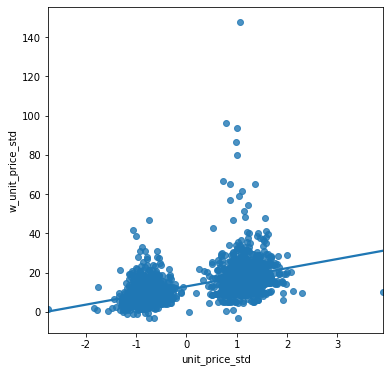

In [59]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='unit_price_std', y='w_unit_price_std', data=db, ci=None)
# Display
plt.show()

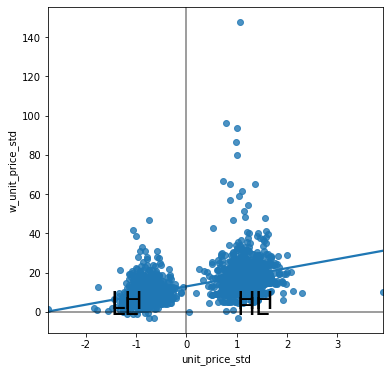

In [60]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='unit_price_std', y='w_unit_price_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

In [61]:
# 計算LISA(因為有孤島所以沒辦法算)
lisa = esda.moran.Moran_Local(db['unit_price_w'], w)

ValueError: cannot assign slice from input of different size

In [ ]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

## 檢驗殘差
### 1.Global Autocorrelation

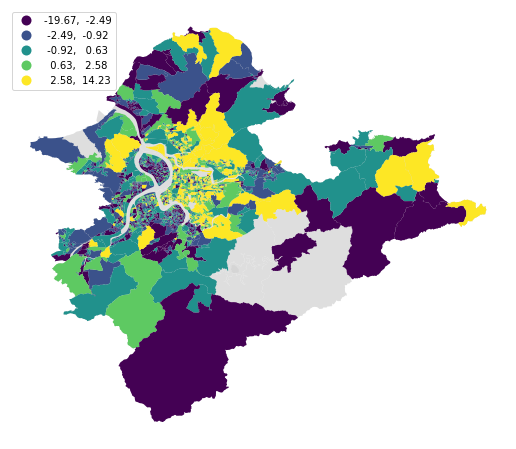

In [62]:
# 殘差繪圖
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(ax=ax,facecolor='lightgray', edgecolor='k',alpha=0.75,linewidth=0.,figsize=(16, 12))
db.plot(column='residual', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax)
ax.set_axis_off()

In [63]:
# spatial_lag
db['residual_lag'] = weights.spatial_lag.lag_spatial(w, db['residual'])
db.head()

,code2,unit_price_w,area,age,shifting_area,pattern_room,pattern_hall,pattern_health,building_area,mrtstation,...,ancestralhall,wastewater,lpg,geometry,residual,unit_price_lag,unit_price_std,unit_price_lag_std,w_unit_price_std,residual_lag
0,A6308-37,17.744496,31.293043,22.072464,134.774058,2.608696,1.666667,1.739130,77.954638,0,...,0,0,0,"MULTIPOLYGON (((121.56388 24.99625, 121.56363 ...",4.532199,105.708032,0.945121,0.931448,21.228892,2.856064
1,A6308-68,16.964316,31.266436,22.980198,124.734455,2.405941,1.623762,1.564356,76.798614,0,...,0,0,0,"MULTIPOLYGON (((121.58536 24.98994, 121.58547 ...",2.107101,36.130154,0.765217,-0.880485,5.184724,3.675935
2,A6308-55,18.138316,32.612368,24.210526,129.128947,2.000000,1.447368,1.315789,82.248421,0,...,0,0,0,"MULTIPOLYGON (((121.56344 24.99130, 121.56295 ...",1.493103,54.141481,1.035933,-0.411438,9.338009,1.981446
3,A6305-40,18.953515,29.399859,25.112676,124.392394,2.183099,1.521127,1.450704,82.319155,0,...,0,0,0,"MULTIPOLYGON (((121.51906 25.02647, 121.51915 ...",2.312384,119.873071,1.223912,1.300332,24.495250,4.014065
4,A6308-20,19.312234,22.616071,20.875000,118.527143,2.517857,1.482143,1.428571,71.620357,0,...,0,0,0,"MULTIPOLYGON (((121.54693 25.00245, 121.54709 ...",6.259805,102.924115,1.306630,0.858950,20.586940,1.560144


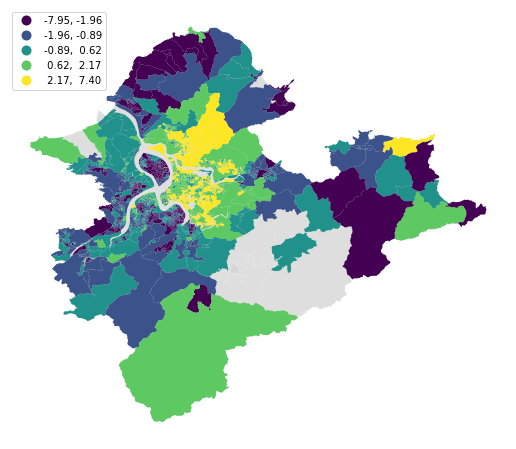

In [64]:
# spatial lag繪圖
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(ax=ax,facecolor='lightgray', edgecolor='k',alpha=0.75,linewidth=0.,figsize=(16, 12))
db.plot(column='residual_lag', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax)
ax.set_axis_off()

In [65]:
# 單價和單價lag標準化
db['residual_std'] = (db['residual'] - db['residual'].mean()) / db['residual'].std()
db['residual_lag_std'] = ( db['residual_lag'] - db['residual_lag'].mean()) / db['residual_lag'].std()

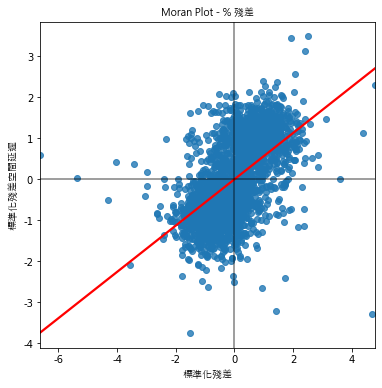

In [66]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(x='residual_std', y='residual_lag_std', 
                ci=None, data=db, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_xlabel('標準化殘差',fontproperties=font)
ax.set_ylabel('標準化殘差空間延遲',fontproperties=font)
ax.set_title('Moran Plot - % 殘差',fontproperties=font)
plt.show()

In [67]:
# 計算moran's i
moran = esda.moran.Moran(db['residual'], w)
moran.I

0.40388434593632766

In [68]:
# empirical p-value:夠小的p-vale允許拒絕地圖是隨機的假設
moran.p_sim

0.001

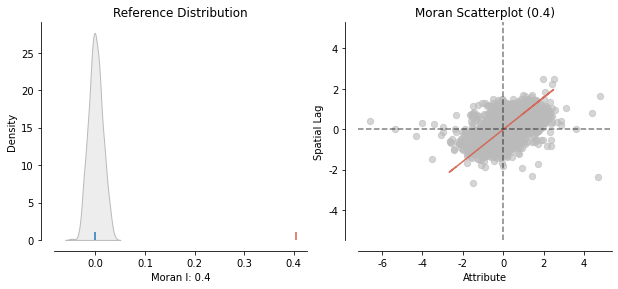

In [69]:
plot_moran(moran);

### 2.Local Autocorrelation

In [70]:
db['w_residual_std'] = ( db['residual_lag'] - db['residual'].mean() ) / db['residual'].std()

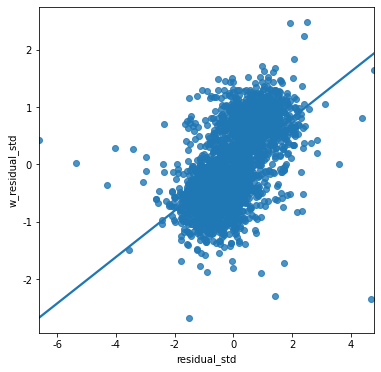

In [71]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='residual_std', y='w_residual_std', data=db, ci=None)
# Display
plt.show()

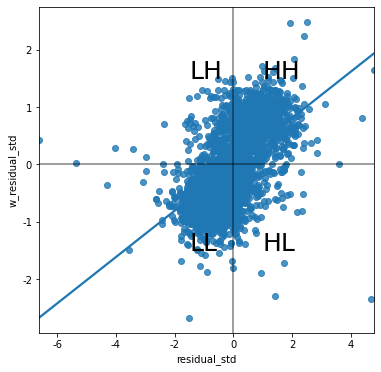

In [72]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='residual_std', y='w_residual_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

In [73]:
# 計算LISA(因為有孤島所以沒辦法算)
lisa = esda.moran.Moran_Local(db['residual'], w)

ValueError: cannot assign slice from input of different size

In [74]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

NameError: name 'lisa' is not defined

-----------------
# 空間延遲模型(spatial lag model, SLM)

In [75]:
m2 = spreg.ML_Lag(
    # Dependent variable
    db[[dep_var]].values, 
    # Independent variables
    db[ind_var].values,
    # Spatial weights matrix
    w=w, 
    # Dependent variable name
    name_y=dep_var, 
    # Independent variables names
    name_x=ind_var
)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minimize.py:779: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [76]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :unit_price_w                Number of Observations:        2198
Mean dependent var  :     13.6458                Number of Variables   :          35
S.D. dependent var  :      4.3366                Degrees of Freedom    :        2163
Pseudo R-squared    :      0.9307
Spatial Pseudo R-squared:  0.8007
Sigma-square ML     :       1.323                Log likelihood        :   -3703.658
S.E of regression   :       1.150                Akaike info criterion :    7477.316
                                                 Schwarz criterion     :    7676.651

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [77]:
# r-square
spreg.r2(m2)

0.9296218032930911

In [78]:
# Adj r-square
spreg.ar2(m2)

0.9285155348289048

In [79]:
# AIC
spreg.akaike(m2)

7477.315622314245

------
# 空間誤差模型(spatial error model, SEM)

In [80]:
m3 = spreg.ML_Error(
    # Dependent variable
    db[[dep_var]].values, 
    # Independent variables
    db[ind_var].values,
    # Spatial weights matrix
    w=w, 
    # Dependent variable name
    name_y=dep_var, 
    # Independent variables names
    name_x=ind_var
)

In [81]:
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :unit_price_w                Number of Observations:        2198
Mean dependent var  :     13.6458                Number of Variables   :          34
S.D. dependent var  :      4.3366                Degrees of Freedom    :        2164
Pseudo R-squared    :      0.0506
Sigma-square ML     :       1.021                Log likelihood        :   -3501.621
S.E of regression   :       1.010                Akaike info criterion :    7071.241
                                                 Schwarz criterion     :    7264.882

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [82]:
#m3.utu = np.square(m3.u).sum()

In [83]:
# r-square
spreg.r2(m3)

-0.04506268345511666

In [84]:
# Adj r-square
spreg.ar2(m3)

-0.06099940644680757

In [85]:
# AIC
spreg.akaike(m3)

7071.241261531991

------
# 模型評估

In [86]:
m1y = pd.DataFrame(np.concatenate((m1.y, m1.predy), axis=1),columns=['y','predy'])
m2y = pd.DataFrame(np.concatenate((m2.y, m2.predy), axis=1),columns=['y','predy'])
m3y = pd.DataFrame(np.concatenate((m3.y, m3.predy), axis=1),columns=['y','predy'])

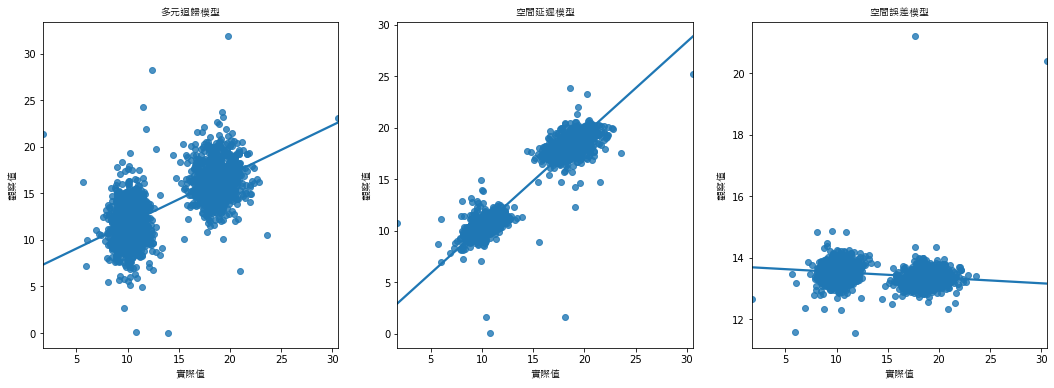

In [87]:
# Setup the figure and axis
f, ax = plt.subplots(1,3, figsize=(18, 6))
# Plot values
seaborn.regplot(x='y', y='predy', data=m1y, ci=None,ax=ax[0])
ax[0].set_title("多元迴歸模型",fontproperties=font)
ax[0].set_xlabel('實際值',fontproperties=font)
ax[0].set_ylabel('觀察值',fontproperties=font)
seaborn.regplot(x='y', y='predy', data=m2y, ci=None,ax=ax[1])
ax[1].set_title("空間延遲模型",fontproperties=font)
ax[1].set_xlabel('實際值',fontproperties=font)
ax[1].set_ylabel('觀察值',fontproperties=font)
seaborn.regplot(x='y', y='predy', data=m3y, ci=None,ax=ax[2])
ax[2].set_title("空間誤差模型",fontproperties=font)
ax[2].set_xlabel('實際值',fontproperties=font)
ax[2].set_ylabel('觀察值',fontproperties=font)
# Display
plt.show()

------
# 最終模型

In [86]:
pick_ind_var = [ind_var[x-1] for x in [1,2,3,4,5,6,9,11,30,33]]
m_final = spreg.GM_Lag(
    # Dependent variable
    db[[dep_var]].values, 
    # Independent variables
    db[pick_ind_var].values,
    # Spatial weights matrix
    w=w, 
    # Dependent variable name
    name_y=dep_var, 
    # Independent variables names
    name_x=pick_ind_var
)
print(m_final.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :unit_price_w                Number of Observations:       24553
Mean dependent var  :     13.6108                Number of Variables   :          12
S.D. dependent var  :      5.0724                Degrees of Freedom    :       24541
Pseudo R-squared    :      0.7048
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       1.3650870       0.1024171      13.3287007       0.0000000
                area       0.0004313       0.0000675       6.3872656       0.0000000
                 ag

In [88]:
db.to_file('dataframe.shp') 

<ipython-input-88-0280e19d7287>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  db.to_file('dataframe.shp')


--------